# ANN Homework 1
* due 2021/11/01 14:00
* Author: Hung Chun Hsu (許鴻君)
* StudentID: R10946017
* Department: Data Science Program

---

##### 1. 請說明類神經網絡的特性與優點。...


---
##### 2. Give one example for each of the following topics:
(a) A book on neural networks or neuroinformatics:
> 	Deep Learning, Ian Goodfellow, Yoshua Bengio, Aaron CourvilleISBN: 0262035618, 9780262035613

---
##### 8. 延伸例題4.7改變模擬函數，如下所示：
$f(x,y) = \text{sin }x+2y^2$, where  $\text{x, y}\in(1,10)$

    (a) 產生三組資料群...

In [1]:
import math
import numpy as np

# Some Hyperparameters
TRAIN_DATA_SIZE = 300
VALIDATION_DATA_SIZE = 100
TEST_DATA_SIZE = 100
BATCH_SIZE = 100
EPOCH = 10000
EPOCH_PRINT_FREQUENCY = 500
use_input_normalization = 0

# declare function f(x,y)
def f(x,y):
    return math.sin(x)+2*y**2

# create training data matrix included 300 vectors of dimension 2.
train_data = np.random.uniform(low=1, high=10, size=(2,TRAIN_DATA_SIZE))

# create training data matrix included 300 vectors of dimension 2.
validation_data = np.random.uniform(low=1, high=10, size=(2,VALIDATION_DATA_SIZE))

# create training data matrix included 300 vectors of dimension 2.
test_data = np.random.uniform(low=1, high=10, size=(2,TEST_DATA_SIZE))

print(train_data.shape)
for i in range(5):
    print(train_data[:,i])
print(train_data[:,0].shape)

train_label = []; validation_label = []; test_label = []
for i in range(len(train_data[0,:])):
    train_label.append(f(train_data[0,i], train_data[1,i]))

for i in range(5):
    print(train_label[i])

# print(np.array(train_label).shape)
train_dataset = np.vstack((train_data, train_label))
#print(train_dataset)

(2, 300)
[7.41050023 4.9489235 ]
[8.16044458 3.22483487]
[4.85887069 3.75194108]
[4.16404563 8.77723843]
[5.9099537 6.1401681]
(2,)
49.88695098266489
21.752526507544875
27.16483294999091
153.2264397933786
75.03870222764512


###### plot the dots of training/validation/testing data scattered in space separately.

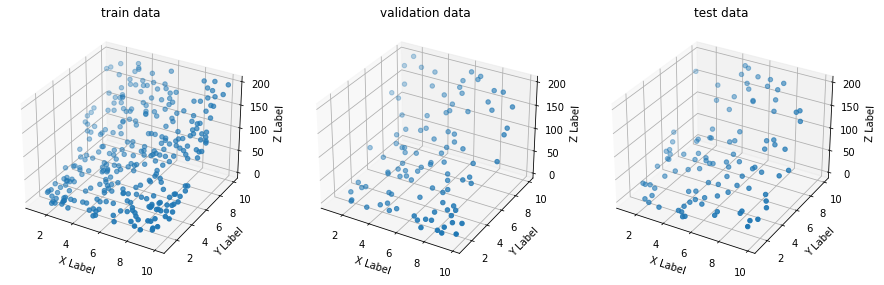

In [2]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(131, projection='3d')



xs = train_data[0,:]; ys = train_data[1,:]; zs = train_label
ax1.scatter(xs, ys, zs)
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
ax1.set_title('train data')

ax2 = fig.add_subplot(132, projection='3d')
for i in range(len(validation_data[0,:])):
    validation_label.append(f(validation_data[0,i], validation_data[1,i]))
xs = validation_data[0,:]; ys = validation_data[1,:]; zs = validation_label
ax2.scatter(xs, ys, zs)
ax2.set_xlabel('X Label')
ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z Label')
ax2.set_title('validation data')

ax3 = fig.add_subplot(133, projection='3d')
for i in range(len(test_data[0,:])):
    test_label.append(f(test_data[0,i], test_data[1,i]))
xs = test_data[0,:]; ys = test_data[1,:]; zs = test_label
ax3.scatter(xs, ys, zs)
ax3.set_xlabel('X Label')
ax3.set_ylabel('Y Label')
ax3.set_zlabel('Z Label')
ax3.set_title('test data')

plt.show()

---
(b) 以類神經網路來訓練、測試及推估函數

In [3]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, Sequential

# data length
train_data_size = len(train_data[0])
validation_data_size = len(validation_data[0])
test_data_size = len(test_data[0])

# Define Neural Network
class NETWORK(nn.Module):
    def __init__(self):
        super(NETWORK, self).__init__()
        self.model1 = Sequential(
            nn.Linear(2,36),
            nn.ReLU(),
            #nn.Linear(4,4),
            #nn.ReLU(),
            nn.Linear(36,1)
        )
    def forward(self, x):
        x = self.model1(x)
        return x

network = NETWORK()

# Set loss function
loss_fn = nn.MSELoss()
learning_rate = 0.2

#optimizer = torch.optim.Adagrad(network.parameters(), lr=learning_rate)
optimizer = torch.optim.Adadelta(network.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=0.9)
print(optimizer)
exit()

# set parameters
total_train_step = 0
total_test_step = 0

# Input Normalization
#mean_of_train_data = np.sum(train_data)/len(train_data[1])
#print(f'Mean of training data:{mean_of_train_data}')
if (use_input_normalization==1):
    std = np.linalg.norm(train_data)
    train_data = train_data/std
# print(train_data)

def get_batch(train_dataset):
    # 隨機從 train data 中抽出 50組 樣本 進行訓練。
    train_dataset = np.transpose(train_dataset)
    #print(f'dimension of train dataset: {np.array(train_dataset.shape)}')
    number_of_rows = train_dataset.shape[0]
    random_inidices = np.random.choice(number_of_rows, size=BATCH_SIZE, replace=False)
    batch_train_dataset = train_dataset[random_inidices, :]

    #print(batch_train_dataset)
    batch_train_data, batch_train_label = np.hsplit(batch_train_dataset, [2])
    batch_train_data = np.transpose(batch_train_data)
    batch_train_label = np.squeeze(batch_train_label)
    batch_train_data = Variable(torch.Tensor(batch_train_data))
    batch_train_label = Variable(torch.Tensor(batch_train_label))
    #print(batch_train_label)

    return batch_train_data, batch_train_label

# 建立資料夾以儲存training log
import os
from pathlib import Path
from Get_Current_time_and_date import *
import json
dir_path = Path(Get_Current_time_and_date())
os.mkdir(dir_path)
print("directory successfully created")

# 將 config 以 config.json 格式存入資料夾
config = {
    "train_data_size" : TRAIN_DATA_SIZE,
    "validation_data_size" : VALIDATION_DATA_SIZE,
    "test_data_size" : TEST_DATA_SIZE,
    "batch_size" : BATCH_SIZE,
    "epoch" : EPOCH,
    "epoch printing frequency" : EPOCH_PRINT_FREQUENCY,
    "USe Input Normalization (BOOLEAN)" : use_input_normalization,
}
with open(os.path.join(dir_path, "config.json"), mode="w") as file:
    json.dump(config, file, indent=1)


for epoch in range(EPOCH):
    if epoch % EPOCH_PRINT_FREQUENCY == 0:
        print(f"===EPOCH:{epoch}===")

    # set to training mode
    network.train()
    batch_train_data, batch_train_label = get_batch(train_dataset)

    for i in range(len(batch_train_data[1])):
            #print(train_data[:][data])
        inputs = batch_train_data[:,i]
            #inputs = torch.Tensor(inputs)
        outputs = network(inputs)

        loss = loss_fn(outputs, batch_train_label[i])

        # something about optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_step = total_train_step + 1

    # set to test mode
    network.eval()
    total_validation_loss = 0
    absone_total_accuracy = 0
    fiveper_total_accuracy = 0
    tenper_total_accuracy = 0
    min_validation_loss = np.inf

    with torch.no_grad():
        for i in range(len(validation_data[0])):
            inputs = validation_data[:,i]
            inputs = torch.Tensor(inputs)

            outputs = network(inputs)
            loss = outputs - validation_label[i]
            total_validation_loss = total_validation_loss + loss

            if abs(outputs - validation_label[i]) < 1: absone_accuracy = 1
            else: absone_accuracy = 0
            absone_total_accuracy = absone_total_accuracy + absone_accuracy
            if abs(outputs - validation_label[i]) < 0.05*validation_label[i]: fiveper_accuracy = 1
            else: fiveper_accuracy = 0
            fiveper_total_accuracy = fiveper_total_accuracy + fiveper_accuracy
            if abs(outputs - validation_label[i]) < 0.1*validation_label[i]: tenper_accuracy = 1
            else: tenper_accuracy = 0
            tenper_total_accuracy = tenper_total_accuracy + tenper_accuracy

    if epoch % EPOCH_PRINT_FREQUENCY == 0:
        print("Loss of validation dataset: {}".format(total_validation_loss))
        print(f"Overall accuracy of validation dataset:")
        absone = absone_total_accuracy/validation_data_size
        fiveper = fiveper_total_accuracy/validation_data_size
        tenper = tenper_total_accuracy/validation_data_size
        print(f"   +-1: {absone} = {absone_total_accuracy}/{validation_data_size}")
        print(f"   5% : {fiveper} = {fiveper_total_accuracy}/{validation_data_size}")
        print(f"   10%: {tenper} = {tenper_total_accuracy}/{validation_data_size}")

        with open(os.path.join(dir_path,"training_log.txt"), "a", encoding="utf-8") as file:
            current_time = Get_Current_time()
            file.write(f"Time: {current_time}, Step: {total_test_step:5d}, +-1: {absone:.2f}, 5%: {fiveper:.2f}, 10%: {tenper:.2f}, Loss: {loss}\n")

    total_test_step = total_test_step + 1

    if loss < min_validation_loss:
        # print(f"Best Model Saved with loss:{loss}")
        torch.save(network.state_dict(), os.path.join(dir_path, "model.ckpt"))

Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.2
    rho: 0.9
    weight_decay: 0
)
directory successfully created
===EPOCH:0===
Loss of validation dataset: tensor([-6996.8677])
Overall accuracy of validation dataset:
   +-1: 0.01 = 1/100
   5% : 0.0 = 0/100
   10%: 0.0 = 0/100


c:\users\woody\desktop\(mon_567)_artificial_neural_network\homework\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


===EPOCH:500===
Loss of validation dataset: tensor([-155.1077])
Overall accuracy of validation dataset:
   +-1: 0.18 = 18/100
   5% : 0.32 = 32/100
   10%: 0.59 = 59/100
===EPOCH:1000===
Loss of validation dataset: tensor([-57.9021])
Overall accuracy of validation dataset:
   +-1: 0.37 = 37/100
   5% : 0.74 = 74/100
   10%: 0.82 = 82/100
===EPOCH:1500===
Loss of validation dataset: tensor([-39.2029])
Overall accuracy of validation dataset:
   +-1: 0.65 = 65/100
   5% : 0.79 = 79/100
   10%: 0.85 = 85/100
===EPOCH:2000===
Loss of validation dataset: tensor([-9.7269])
Overall accuracy of validation dataset:
   +-1: 0.7 = 70/100
   5% : 0.8 = 80/100
   10%: 0.88 = 88/100
===EPOCH:2500===
Loss of validation dataset: tensor([-6.9969])
Overall accuracy of validation dataset:
   +-1: 0.76 = 76/100
   5% : 0.81 = 81/100
   10%: 0.91 = 91/100
===EPOCH:3000===
Loss of validation dataset: tensor([-14.3563])
Overall accuracy of validation dataset:
   +-1: 0.78 = 78/100
   5% : 0.81 = 81/100
   10%

=== Test on test dataset ===
NETWORK(
  (model1): Sequential(
    (0): Linear(in_features=2, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=1, bias=True)
  )
)
Loss of test dataset: tensor([1.6327], grad_fn=<AddBackward0>)
Overall accuracy of test dataset:
   +-1: 0.85 = 85/100
   5% : 0.91 = 91/100
   10%: 0.96 = 96/100


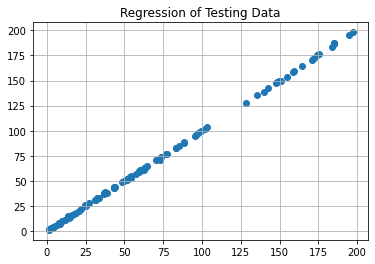

In [4]:
# Testing Procedure
#network.test()
print("=== Test on test dataset ===")
#test_model = torch.load(os.path.join(dir_path, "model.ckpt"))
test_model = NETWORK()
test_model.load_state_dict(torch.load(os.path.join(dir_path, "model.ckpt")))
print(test_model)
total_test_loss = 0
absone_total_accuracy = 0
fiveper_total_accuracy = 0
tenper_total_accuracy = 0
test_predict = []
for i in range(len(test_data[0])):
            inputs = test_data[:,i]
            inputs = torch.Tensor(inputs)

            outputs = test_model(inputs)
            test_predict.append(float(outputs.detach().numpy()))
            loss = outputs - test_label[i]
            total_test_loss = total_test_loss + loss

            if abs(outputs - test_label[i]) < 1: absone_accuracy = 1
            else: absone_accuracy = 0
            absone_total_accuracy = absone_total_accuracy + absone_accuracy
            if abs(outputs - test_label[i]) < 0.05*test_label[i]: fiveper_accuracy = 1
            else: fiveper_accuracy = 0
            fiveper_total_accuracy = fiveper_total_accuracy + fiveper_accuracy
            if abs(outputs - test_label[i]) < 0.1*test_label[i]: tenper_accuracy = 1
            else: tenper_accuracy = 0
            tenper_total_accuracy = tenper_total_accuracy + tenper_accuracy

print("Loss of test dataset: {}".format(total_test_loss))
print(f"Overall accuracy of test dataset:")
absone = absone_total_accuracy/validation_data_size
fiveper = fiveper_total_accuracy/validation_data_size
tenper = tenper_total_accuracy/validation_data_size
print(f"   +-1: {absone} = {absone_total_accuracy}/{validation_data_size}")
print(f"   5% : {fiveper} = {fiveper_total_accuracy}/{validation_data_size}")
print(f"   10%: {tenper} = {tenper_total_accuracy}/{validation_data_size}")
with open(os.path.join(dir_path,"training_log.txt"), "a", encoding="utf-8") as file:
    current_time = Get_Current_time()
    # Save Model Structure
    file.write(f"===== Model Structure =====\n{test_model}\n")
    file.write(f"===== Optimizer =====\n{optimizer}\n")
    file.write(f"===== Testing Result =====\n")
    file.write(f"Time: {current_time}, Loss: {loss}\n  +-1: {absone:.2f}\n   5%: {fiveper:.2f}\n  10%: {tenper:.2f}, \n")

#print(test_predict)
#print(test_label)

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
plt.scatter(test_predict, test_label)
plt.title('Regression of Testing Data')
plt.grid()

plt.show()

#### Plot the regression